# Random Forest Forecast

C:\Users\UlamKetum\AppData\Local\Temp\ipykernel_84420\2250062249.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
C:\Users\UlamKetum\AppData\Local\Temp\ipykernel_84420\2250062249.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_lagged[f'{col}_t-{i}'] = df[col].shift(i)
C:\Users\UlamKetum\AppData\Local\Temp\ipykernel_84420\2250062249.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_lagged[f'

Predicted rainfall for the next 30 days:
[ 61.0579  52.6221  48.3628  45.6986  46.5334  46.9334  47.6015  48.5785
  49.0495  50.3329  50.7159  51.5532  69.1815  69.1769  68.3626  69.2824
  69.9028  70.0144  72.3667  72.187   72.671   72.3643  72.2924  72.5454
  94.2058 105.3426 104.8276 104.7898 106.0201 107.0637]


c:\Users\UlamKetum\rainfall-prediction\.virt\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\UlamKetum\rainfall-prediction\.virt\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\UlamKetum\rainfall-prediction\.virt\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


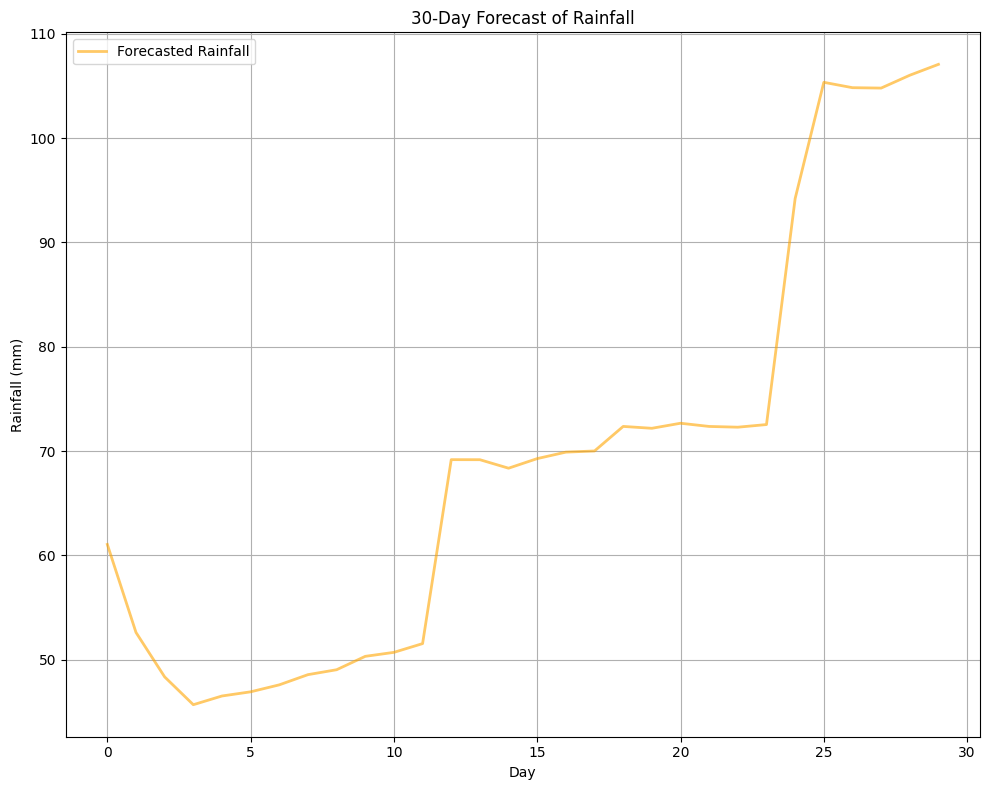

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pandas import DataFrame
import pickle

# Load and preprocess the data
df = pd.read_csv('data/lawas-daily-data.csv', encoding='latin')

df['Wind Speed'] = df['Wind Speed'].replace(np.nan, 0)
df = df.fillna(method='ffill')

# Select features and target
data_input = df[['Total_Rainfall', 'ANOM', 'Flood_Height_Max', 'Pressure', 'Temperature', 'Dew Point', 'Humidity', 'Wind Speed']]

# Scaling the features and target separately
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Function to create lagged features for all columns in the dataframe
def create_lagged_features(df, num_lags):
    df_lagged = DataFrame()
    for col in df.columns:
        for i in range(num_lags, 0, -1):
            df_lagged[f'{col}_t-{i}'] = df[col].shift(i)
    df_lagged['Current_Rainfall'] = df['Total_Rainfall']
    df_lagged.dropna(inplace=True)
    return df_lagged

# Create lagged dataset for forecasting using all columns
num_lags = 30  # Number of lagged values to use for forecasting
df_lagged = create_lagged_features(data_input, num_lags)

# Separate features (lags of all columns) and target (Current_Rainfall)
features = df_lagged.drop(columns=['Current_Rainfall'])
target = df_lagged['Current_Rainfall']

# Scale features and target
features_scaled = feature_scaler.fit_transform(features)
target_scaled = target_scaler.fit_transform(target.values.reshape(-1, 1))

# Split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(features_scaled, target_scaled, test_size=0.30, random_state=100, shuffle=False)

# Train Random Forest Regressor
# rf = RandomForestRegressor(n_estimators=1000, random_state=42)
# rf.fit(x_train, y_train.ravel())
# with open("RF_model.pkl", 'wb') as file:  
#     pickle.dump(rf, file)

with open('RF_model.pkl', 'rb') as f:
    rf = pickle.load(f)

# Forecasting function
def forecast(model, initial_input, num_steps, feature_scaler, target_scaler):
    predictions = []
    current_input = initial_input

    for i in range(num_steps):
        current_input_scaled = feature_scaler.transform(current_input.reshape(1, -1))
        pred_scaled = model.predict(current_input_scaled)
        pred = target_scaler.inverse_transform(pred_scaled.reshape(-1, 1))
        predictions.append(pred[0][0])

        # Shift the input to include the new prediction as the latest 'lag'
        current_input = np.roll(current_input, -1)
        current_input[-1] = pred[0][0]

    return np.array(predictions)

# Forecast future values
forecast_length = 30  # For example, forecasting the next 30 days
initial_input = df_lagged.iloc[-1, :-1].values  # Take the last available data point as the starting input
predictions = forecast(rf, initial_input, forecast_length, feature_scaler, target_scaler)

# Output results
print(f"Predicted rainfall for the next {forecast_length} days:")
print(predictions)

# Plot forecasted values
plt.plot(predictions, label='Forecasted Rainfall', color='orange', alpha=0.6, linestyle='-', linewidth=2)
plt.xlabel('Day')
plt.ylabel('Rainfall (mm)')
plt.title(f'{forecast_length}-Day Forecast of Rainfall')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

c:\Users\UlamKetum\rainfall-prediction\.virt\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\UlamKetum\rainfall-prediction\.virt\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\UlamKetum\rainfall-prediction\.virt\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\UlamKetum\rainfall-prediction\.virt\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\UlamKetum\rainfall-prediction\.virt\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\U

Predicted rainfall for the next 30 days:
[ 27.7388  40.2086  21.2048  35.3418  32.839   31.7909  33.6111  42.4611
  42.2968  47.2049  41.2879  44.2954  66.7812  63.6572  66.3028  68.363
  70.4848  70.8188  71.4391  71.0535  72.4224  70.5936  71.65    71.4697
  93.6161 104.9512 104.2507 103.9487 105.5444 106.5992]


c:\Users\UlamKetum\rainfall-prediction\.virt\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\UlamKetum\rainfall-prediction\.virt\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\UlamKetum\rainfall-prediction\.virt\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\UlamKetum\rainfall-prediction\.virt\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


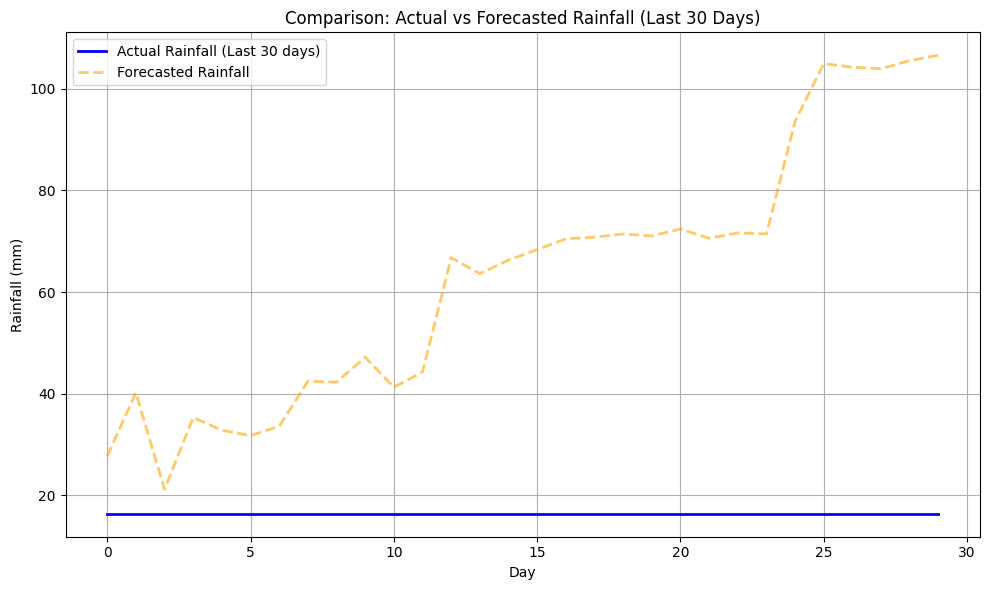

In [21]:
# Forecast future values
forecast_length = 30  # For example, forecasting the next 30 days
initial_input = df_lagged.iloc[-30, :-1].values  # Take the last available data point as the starting input
predictions = forecast(rf, initial_input, forecast_length, feature_scaler, target_scaler)

# Get the actual rainfall data for the 30 days before the last observation
actual_rainfall_last_30_days = df_lagged['Current_Rainfall'].values[-30:]

# Output results
print(f"Predicted rainfall for the next {forecast_length} days:")
print(predictions)

# Plot forecasted vs actual values
plt.figure(figsize=(10, 6))

# Plot actual rainfall (30 days before the last observation)
plt.plot(range(forecast_length), actual_rainfall_last_30_days, label='Actual Rainfall (Last 30 days)', color='blue', linestyle='-', linewidth=2)

# Plot forecasted rainfall
plt.plot(range(forecast_length), predictions, label='Forecasted Rainfall', color='orange', alpha=0.6, linestyle='--', linewidth=2)

# Labels and title
plt.xlabel('Day')
plt.ylabel('Rainfall (mm)')
plt.title(f'Comparison: Actual vs Forecasted Rainfall (Last {forecast_length} Days)')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()
